# PINNSim simulation

In this notebook, we demonstrate a simulation with PINNSim.

In [1]:
from pinnsim.configurations.load_dynamic_case import load_equilibrium_case
from pinnsim.numerics import PredictorStatic, SimulatorAssimulo, SimulatorDistributed
from pinnsim.post_processing.rebuild_nn_model import load_model_from_local_files
from pinnsim.post_processing.grid_trajectory_plot import GridTrajectoryPlot

Could not find GLIMDA.


The setup of the numerical experiment is exactly the same as in `simulation_ieee9_conventional.ipynb`.

In [2]:

grid_model, equilibrium_state_list, equilibrium_control_input_list, theta, V = (
        load_equilibrium_case(case="ieee9")
    )

simulator_exact = SimulatorAssimulo(grid_model=grid_model)
equilibrium_control_input_list[0][:, 0] *= 0.5
time_end = 2.5

results_exact = simulator_exact.simulate_trajectory(
        time_end=time_end,
        component_state_list_initial=equilibrium_state_list,
        control_input_list=equilibrium_control_input_list,
        theta_initial=theta,
        V_initial=V,
    )

### Setting up PINNSim

The centre piece of PINNSim are the NN models for each component. We reference them by the `run_id` given by WandB (see `pinn_training.ipynb` and `pinn_training_sweeps.ipynb`) and they could be loaded as shown below.

In [3]:
run_ids = ["w4f2r6un", "g3qggf8t", "86nr089h"]
nn_models = [load_model_from_local_files(run_id = run_id)[0] for run_id in run_ids]

For PINNSim we need to define a `Predictor` for each component. This `Predictor` determines how the state evolution of the corresponding component will be computed. Examples (see `pinnsim.numerics.predictors`) are the Forward Euler or the RK4 predictor. The trained NNs provide exactly the same functionality, however, for large time step with significantly higher accuracy. To align their interfaces, the NN models and predictors all implement the following three methods, all as function of the prediction time $t$, the initial state $x_0$, the control input $u$, and the voltage parametrisation $\Xi$
- `predict_state`: $(t, x_0, u, \Xi) \mapsto \hat{x}$ -- the resulting state
- `predict_current`: $(t, x_0, u, \Xi) \mapsto (I_D, I_Q)$ -- the current injection to the grid in the grid reference frame
- `predict_current_jacobian`: $(t, x_0, u, \Xi) \mapsto (I_D, I_Q, \frac{\partial I_D}{\partial \Xi}, \frac{\partial I_Q}{\partial \Xi})$ -- the current injection to the grid in the grid reference frame and their sensitivity to changes in the voltage parametrisation

For further details, we recommend consulting Algorithm 1 in the referenced paper (see the `README`) and the file `simulator_distributed.py`.

For PINNSim, we add the list of run ids to the list of predictor schemes as they correspond to the first three components in the `grid_model`. As we also have three load components, we add three `PredictorStatic` classes to the list of predictor schemes. In the setup of the simulator, the NN models will be loaded and the predictors matched with the respective component.

In [4]:
predictor_schemes = run_ids + [PredictorStatic] * 3

simulator_distributed = SimulatorDistributed(
    grid_model=grid_model,
    timestep_size=0.25,
    predictor_schemes=predictor_schemes,
    voltage_profile_order=2,
    n_extra_points=5,
    border_points=False,
)

### Simulation and plotting

The simulation and plotting of the results is set up identically to the other numerical methods. All simulators inherit from `SimulatorModule` in `pinnsim.numerics.simulators` to ensure the same interface. Iterative solvers as the trapezoidal method and PINNSim also share a common parent class `SimulatorIterative`.

C:\Users\jstiasny\.python\pinnsim_pscc\src\pinnsim\post_processing\grid_trajectory_plot.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


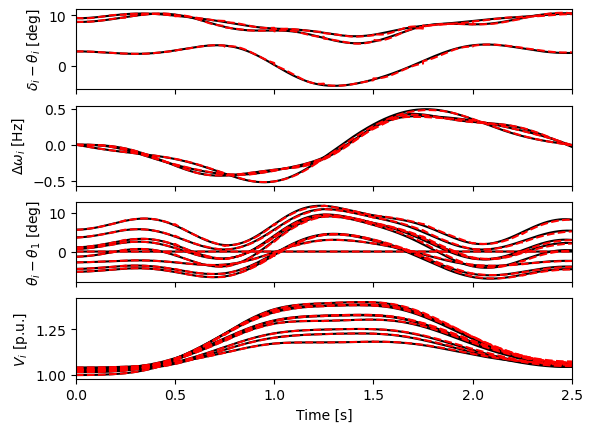

In [5]:
results_distributed = simulator_distributed.simulate_trajectory(
        time_end=time_end,
        component_state_list_initial=equilibrium_state_list,
        control_input_list=equilibrium_control_input_list,
        theta_initial=theta,
        V_initial=V,
    )

plot_object = GridTrajectoryPlot(grid_model=grid_model)
plot_object.add_results(results_data=results_exact)
plot_object.add_results(results_data=results_distributed, line_style="--r")
plot_object.show_plot(time_end=time_end)

As we can observe, even for a time step size of 0.25s the resulting trajectories closely match the exact ones.